In [44]:
import os
import importlib
import numpy as np
import tensorflow as tf

import texar.tf as tx
from texar.tf.modules import WordEmbedder, UnidirectionalRNNEncoder, \
        MLPTransformConnector, AttentionRNNDecoder, \
        GumbelSoftmaxEmbeddingHelper, Conv1DClassifier
from texar.tf.core import get_train_op
from texar.tf.utils import collect_trainable_variables, get_batch_size

from texar.tf.data import MultiAlignedData, FeedableDataIterator

from texar import HParams

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import copy

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import csv

In [45]:
config = {
    'max_nepochs': 12, # Total number of training epochs
                 # (including pre-train and full-train)
    'pretrain_ae_nepochs': 10, # Number of pre-train epochs (training as autoencoder)
    'display': 500,  # Display the training results every N training steps.
    'display_eval': 1e10, # Display the dev results every N training steps (set to a
                    # very large value to disable it).
    'sample_path': './samples',
    'checkpoint_path': './checkpoints',
    'restore': '',   # Model snapshot to restore from

    'lambda_g': 0.1,    # Weight of the classification loss
    'lambda_z1': 3000.,
    'lambda_z2': 3000.,
    'gamma_decay': 0.5,   # Gumbel-softmax temperature anneal rate

    'change_lambda_ae': 0.,
    'change_lambda_ae_epoch': 12,

    'plot_z': True,
    'plot_max_count': 1000,

    'spam': True,
    'repetitions': True,

    'write_text': True,
    'write_labels': True,

    'manual': True,

    # Data
    'train_data': {
        'batch_size': 64,
        'datasets': [
            {
                'files': './data/yelp/sentiment.train.text',
                'vocab_file': './data/yelp/vocab',
                'data_name': ''
            },
            {
                'files': './data/yelp/sentiment.train.labels',
                'data_type': 'int',
                'data_name': 'labels'
            }
        ],
        'name': 'train'
    }
}

config['val_data'] = copy.deepcopy(config['train_data'])
config['val_data']['datasets'][0]['files'] = './data/yelp/sentiment.dev.text'
config['val_data']['datasets'][1]['files'] = './data/yelp/sentiment.dev.labels'

config['test_data'] = copy.deepcopy(config['train_data'])
config['test_data']['datasets'][0]['files'] = './data/yelp/sentiment.test.text'
config['test_data']['datasets'][1]['files'] = './data/yelp/sentiment.test.labels'

if config['manual']:
    config['manual_data'] = copy.deepcopy(config['train_data'])
    config['manual_data']['datasets'][0]['files'] = './data/yelp/sentiment.manual.text'
    config['manual_data']['datasets'][1]['files'] = './data/yelp/sentiment.manual.labels'

model_dict = {
    'dim_c': 200,
    'dim_z': 500,
    'num_classes': 2,
    'embedder': {
        'dim': 100,
    },
    'encoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700
            },
            'dropout': {
                'input_keep_prob': 0.5
            }
        }
    },
    'decoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700,
            },
            'dropout': {
                'input_keep_prob': 0.5,
                'output_keep_prob': 0.5
            },
        },
        'attention': {
            'type': 'BahdanauAttention',
            'kwargs': {
                'num_units': 700,
            },
            'attention_layer_size': 700,
        },
        'max_decoding_length_train': 21,
        'max_decoding_length_infer': 20,
    },
    'classifier': {
        'kernel_size': [3, 4, 5],
        'filters': 128,
        'other_conv_kwargs': {'padding': 'same'},
        'dropout_conv': [1],
        'dropout_rate': 0.5,
        'num_dense_layers': 0,
        'num_classes': 1
    },
    'opt': {
        'optimizer': {
            'type':  'AdamOptimizer',
            'kwargs': {
                'learning_rate': 5e-4,
            },
        },
    }
}

In [46]:
class CtrlGenModel(object):

    def __init__(self, inputs, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae, hparams=None):
        self._hparams = tx.HParams(hparams, None)
        self._build_model(inputs, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae)


    def _build_model(self, inputs, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae):

        embedder = WordEmbedder(
            vocab_size=vocab.size,
            hparams=self._hparams.embedder)

        encoder = UnidirectionalRNNEncoder(hparams=self._hparams.encoder)

        enc_text_ids = inputs['text_ids'][:, 1:]
        enc_outputs, final_state = encoder(embedder(enc_text_ids),
                                           sequence_length=inputs['length']-1)

        z = final_state[:, self._hparams.dim_c:]

        label_connector = MLPTransformConnector(self._hparams.dim_c)

        labels = tf.to_float(tf.reshape(inputs['labels'], [-1, 1]))

        c = label_connector(labels)
        c_ = label_connector(1 - labels)

        h = tf.concat([c, z], 1)
        h_ = tf.concat([c_, z], 1)

        # Teacher-force decoding and the auto-encoding loss for G

        decoder = AttentionRNNDecoder(
            memory=enc_outputs,
            memory_sequence_length=inputs['length']-1,
            cell_input_fn=lambda inputs, attention: inputs,
            vocab_size=vocab.size,
            hparams=self._hparams.decoder)

        connector = MLPTransformConnector(decoder.state_size)

        g_outputs, _, _ = decoder(
            initial_state=connector(h), inputs=inputs['text_ids'],
            embedding=embedder, sequence_length=inputs['length']-1)

        loss_g_ae = tx.losses.sequence_sparse_softmax_cross_entropy(
            labels=inputs['text_ids'][:, 1:],
            logits=g_outputs.logits,
            sequence_length=inputs['length']-1,
            average_across_timesteps=True,
            sum_over_timesteps=False)

        # Gumbel-softmax decoding, used in training

        start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id

        end_token = vocab.eos_token_id

        gumbel_helper = GumbelSoftmaxEmbeddingHelper(
            embedder.embedding, start_tokens, end_token, gamma)

        soft_outputs_, _, soft_length_, = decoder(
            helper=gumbel_helper, initial_state=connector(h_))

        soft_outputs, _, soft_length, = decoder(
            helper=gumbel_helper, initial_state=connector(h))


        # ---------------------------- SHIFTED LOSS -------------------------------------
        _, encoder_final_state_ = encoder(embedder(soft_ids=soft_outputs_.sample_id),
                                          sequence_length=inputs['length'] - 1)
        _, encoder_final_state = encoder(embedder(soft_ids=soft_outputs.sample_id),
                                         sequence_length=inputs['length'] - 1)
        new_z_ = encoder_final_state_[:, self._hparams.dim_c:]
        new_z = encoder_final_state[:, self._hparams.dim_c:]

        cos_distance_z_ = tf.abs(
            tf.losses.cosine_distance(tf.nn.l2_normalize(z, axis=1), tf.nn.l2_normalize(new_z_, axis=1), axis=1))
        cos_distance_z = tf.abs(
            tf.losses.cosine_distance(tf.nn.l2_normalize(z, axis=1), tf.nn.l2_normalize(new_z, axis=1), axis=1))
        # ----------------------------______________-------------------------------------


        # Greedy decoding, used in eval

        outputs_, _, length_ = decoder(
            decoding_strategy='infer_greedy', initial_state=connector(h_),
            embedding=embedder, start_tokens=start_tokens, end_token=end_token)

        # Creates classifier

        classifier = Conv1DClassifier(hparams=self._hparams.classifier)

        clas_embedder = WordEmbedder(vocab_size=vocab.size,
                                     hparams=self._hparams.embedder)

        # Classification loss for the classifier

        clas_logits, clas_preds = classifier(
            inputs=clas_embedder(ids=inputs['text_ids'][:, 1:]),
            sequence_length=inputs['length']-1)

        loss_d_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=clas_logits)

        loss_d_clas = tf.reduce_mean(loss_d_clas)

        accu_d = tx.evals.accuracy(labels=inputs['labels'], preds=clas_preds)

        # Classification loss for the generator, based on soft samples

        soft_logits, soft_preds = classifier(
            inputs=clas_embedder(soft_ids=soft_outputs_.sample_id),
            sequence_length=soft_length_)

        loss_g_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(1-inputs['labels']), logits=soft_logits)

        loss_g_clas = tf.reduce_mean(loss_g_clas)

        # Accuracy on soft samples, for training progress monitoring

        accu_g = tx.evals.accuracy(labels=1-inputs['labels'], preds=soft_preds)

        # Accuracy on greedy-decoded samples, for training progress monitoring

        _, gdy_preds = classifier(
            inputs=clas_embedder(ids=outputs_.sample_id),
            sequence_length=length_)

        accu_g_gdy = tx.evals.accuracy(
            labels=1-inputs['labels'], preds=gdy_preds)

        # Aggregates losses

        loss_g = lambda_ae * loss_g_ae + \
                 lambda_g * loss_g_clas + \
                 lambda_z1 * cos_distance_z + cos_distance_z_ * lambda_z2
        loss_d = loss_d_clas

        # Creates optimizers

        g_vars = collect_trainable_variables(
            [embedder, encoder, label_connector, connector, decoder])
        d_vars = collect_trainable_variables([clas_embedder, classifier])

        train_op_g = get_train_op(
            loss_g, g_vars, hparams=self._hparams.opt)
        train_op_g_ae = get_train_op(
            loss_g_ae, g_vars, hparams=self._hparams.opt)
        train_op_d = get_train_op(
            loss_d, d_vars, hparams=self._hparams.opt)

        # Interface tensors
        self.losses = {
            "loss_g": loss_g,
            "loss_g_ae": loss_g_ae,
            "loss_g_clas": loss_g_clas,
            "loss_d": loss_d_clas,
            "loss_cos_": cos_distance_z_,
            "loss_cos": cos_distance_z
        }
        self.metrics = {
            "accu_d": accu_d,
            "accu_g": accu_g,
            "accu_g_gdy": accu_g_gdy
        }
        self.train_ops = {
            "train_op_g": train_op_g,
            "train_op_g_ae": train_op_g_ae,
            "train_op_d": train_op_d
        }
        self.samples = {
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs_.sample_id,
            "z_vector": z,
            "labels_source": inputs['labels'],
            "labels_target": 1 - inputs['labels'],
            "labels_predicted": gdy_preds
        }

        self.fetches_train_g = {
            "loss_g": self.train_ops["train_op_g"],
            "loss_g_ae": self.losses["loss_g_ae"],
            "loss_g_clas": self.losses["loss_g_clas"],
            "loss_shifted_ae1": self.losses["loss_cos"],
            "loss_shifted_ae2": self.losses["loss_cos_"],
            "accu_g": self.metrics["accu_g"],
            "accu_g_gdy": self.metrics["accu_g_gdy"]
        }

        self.fetches_train_d = {
            "loss_d": self.train_ops["train_op_d"],
            "accu_d": self.metrics["accu_d"]
        }
        fetches_eval = {"batch_size": get_batch_size(inputs['text_ids'])}
        fetches_eval.update(self.losses)
        fetches_eval.update(self.metrics)
        fetches_eval.update(self.samples)
        self.fetches_eval = fetches_eval

In [47]:
def train_model():
    # Data
    train_data = MultiAlignedData(config['train_data'])
    val_data = MultiAlignedData(config['val_data'])
    test_data = MultiAlignedData(config['test_data'])
    if config['manual']:
        manual_data = MultiAlignedData(config['manual_data'])
    vocab = train_data.vocab(0)

    # Each training batch is used twice: once for updating the generator and
    # once for updating the discriminator. Feedable data iterator is used for
    # such case.
    if config['manual']:
        iterator = tx.data.FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data,
             'val': val_data, 'test': test_data, 'manual': manual_data})
    else:
        iterator = tx.data.FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data,
             'val': val_data, 'test': test_data})
    batch = iterator.get_next()

    # Model
    gamma = tf.placeholder(dtype=tf.float32, shape=[], name='gamma')
    lambda_g = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_g')
    lambda_z1 = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z1')
    lambda_z2 = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z2')
    lambda_ae = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_ae')
    model = CtrlGenModel(batch, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae, model_dict)
    
    def _train_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, verbose=True):
        avg_meters_d = tx.utils.AverageRecorder(size=10)
        avg_meters_g = tx.utils.AverageRecorder(size=10)

        step = 0
        while True:
            try:
                step += 1
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_d'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_
                }

                vals_d = sess.run(model.fetches_train_d, feed_dict=feed_dict)
                avg_meters_d.add(vals_d)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_g'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_
                }
                vals_g = sess.run(model.fetches_train_g, feed_dict=feed_dict)
                avg_meters_g.add(vals_g)

                if verbose and (step == 1 or step % config['display'] == 0):
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_d.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_g.to_str(4)))

                if verbose and step % config['display_eval'] == 0:
                    iterator.restart_dataset(sess, 'val')
                    _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch)

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}'.format(epoch, avg_meters_d.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_g.to_str(4)))
                break
    
    def _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_,lambda_z2_, lambda_ae_, epoch, val_or_test='val',
                    plot_z=False, plot_max_count=1000, spam=False, repetitions=False, write_text=True,
                    write_labels=False):
        avg_meters = tx.utils.AverageRecorder()

        if plot_z:
            z_vectors = []
            labels = []
            tsne = TSNE(n_components=2)
        while True:
            try:
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, val_or_test),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_,
                    tx.context.global_mode(): tf.estimator.ModeKeys.EVAL
                }

                vals = sess.run(model.fetches_eval, feed_dict=feed_dict)

                batch_size = vals.pop('batch_size')

                # Computes BLEU
                samples = tx.utils.dict_pop(vals, list(model.samples.keys()))
                hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)

                refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
                refs = np.expand_dims(refs, axis=1)

                bleu = tx.evals.corpus_bleu_moses(refs, hyps)
                vals['bleu'] = bleu

                if spam or repetitions:
                    target_labels = samples['labels_target']
                    predicted_labels = samples['labels_predicted']

                    results = [(r, h, t, p) for r, h, t, p in zip(refs, hyps, target_labels, predicted_labels)]

                # Computes repetitions
                if repetitions:
                    count_equal_strings = 0
                    remain_samples_e = []
                    for r, h, t, p in results:
                        if r == h:
                            count_equal_strings += 1
                        else:
                            remain_samples_e.append((r, h, t, p))
                    vals['equal'] = count_equal_strings / len(hyps)

                # Computes spam
                if spam:
                    count_spam = 0
                    remain_samples_s = []
                    for r, h, t, p in results:
                        words = h.split()
                        if len(words) > 2 and words[-1] == words[-2]:
                            count_spam += 1
                        elif len(words) > 4 and words[-1] == words[-3] and words[-2] == words[-4]:
                            count_spam += 1
                        else:
                            remain_samples_s.append((r, h, t, p))
                    vals['spam'] = count_spam / len(hyps)

                if repetitions and spam:
                    remain_samples = [sample for sample in remain_samples_e if sample in remain_samples_s]
                    remain_samples = list(remain_samples)
                elif not repetitions and spam:
                    remain_samples = remain_samples_s
                elif repetitions and not spam:
                    remain_samples = remain_samples_e

                if repetitions and spam:
                    refs_remain = [r for r, h, t, p in remain_samples]
                    hyps_remain = [h for r, h, t, p in remain_samples]
                    bleu_remain = tx.evals.corpus_bleu_moses(refs_remain, hyps_remain)
                    vals['bleu_remain'] = bleu_remain

                    if len(remain_samples) != 0:
                        true_labels = 0
                        for _, _, t, p in remain_samples:
                            if t == p:
                                true_labels += 1
                        vals['acc_remain'] = true_labels / len(remain_samples)
                    else:
                        vals['acc_remain'] = 0.

                avg_meters.add(vals, weight=batch_size)

                if plot_z:
                    z_vectors += samples['z_vector'].tolist()
                    labels += samples['labels_source'].tolist()

                # Writes samples
                if write_text:
                    tx.utils.write_paired_text(
                        refs.squeeze(), hyps,
                        os.path.join(config['sample_path'], 'text_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

                # Writes labels samples
                if write_labels:
                    tx.utils.write_paired_text(
                        [str(l) for l in samples['labels_target'].tolist()],
                        [str(l) for l in samples['labels_predicted'].tolist()],
                        os.path.join(config['sample_path'], 'labels_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}: {}'.format(
                    epoch, val_or_test, avg_meters.to_str(precision=4)))
                break

        if plot_z:
            if plot_max_count == 0:
                z_vectors = z_vectors
                labels = labels
            else:
                z_vectors = z_vectors[:plot_max_count]
                labels = labels[:plot_max_count]
            tsne_result = tsne.fit_transform(np.array(z_vectors))
            x_data = tsne_result[:, 0]
            y_data = tsne_result[:, 1]
            
            plt.rcParams["figure.figsize"] = 10, 10
            plt.scatter(x_data, y_data, c=np.array(labels), s=2, cmap=plt.cm.get_cmap('jet', 2))
            plt.clim(0.0, 1.0)
            if not os.path.exists('./images'):
                os.makedirs('./images')
            plt.savefig('./images/{}_{}.png'.format(val_or_test, epoch))
            plt.show()

        return avg_meters.avg()

    tf.gfile.MakeDirs(config['sample_path'])
    tf.gfile.MakeDirs(config['checkpoint_path'])

    # Runs the logics
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        sess.run(tf.tables_initializer())

        saver = tf.train.Saver(max_to_keep=None)
        if config['restore']:
            print('Restore from: {}'.format(config['restore']))
            saver.restore(sess, conig['restore'])

        iterator.initialize_dataset(sess)

        gamma_ = 1.
        lambda_g_ = 0.
        lambda_ae_ = 1.
        lambda_z1_ = config['lambda_z1']
        lambda_z2_ = config['lambda_z2']
        for epoch in range(1, config['max_nepochs']+1):
            if epoch > config['pretrain_ae_nepochs']:
                # Anneals the gumbel-softmax temperature
                gamma_ = max(0.001, gamma_ * config['gamma_decay'])
                lambda_g_ = config['lambda_g']
            if epoch > config['change_lambda_ae_epoch']:
                lambda_ae_ = lambda_ae_ - config['change_lambda_ae']
            print('gamma: {}, lambda_g: {}, lambda_z1: {}, lambda_z2: {}, lambda_ae: {}'.format(
                gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_))

            # Train
            iterator.restart_dataset(sess, ['train_g', 'train_d'])
            _train_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch)

            # Val
            iterator.restart_dataset(sess, 'val')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'val', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            saver.save(
                sess, os.path.join(config['checkpoint_path'], 'ckpt'), epoch)

            # Test
            iterator.restart_dataset(sess, 'test')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'test', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            if config['manual']:
                iterator.restart_dataset(sess, 'manual')
                _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'manual', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

In [48]:
def print_result():
    TEXT_FILE = './samples/text_val.{}'.format(config['max_nepochs'])
    LABELS_FILE = './samples/labels_val.{}'.format(config['max_nepochs'])


    smoothing_function = SmoothingFunction()
    samples = []
    samples.append(['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'])
    with open(TEXT_FILE, 'r') as input_file_text:
        lines_text = input_file_text.readlines()
        with open(LABELS_FILE, 'r') as input_file_labels:
            lines_labels = input_file_labels.readlines()
            for i in range(0, len(lines_text)-1, 2):
                input_sentence = lines_text[i].strip()
                generated_sentence = lines_text[i + 1].strip()
                input_label = 1 - int(lines_labels[i])
                predicted_label = int(lines_labels[i + 1])

                words_input = input_sentence.split()
                words_generated = generated_sentence.split()
                try:
                    score = sentence_bleu([words_input], words_generated, smoothing_function=smoothing_function.method4)
                except Exception:
                    #print(input_sentence)
                    #print(generated_sentence)
                    pass

                samples.append([input_sentence, input_label, generated_sentence, predicted_label, score])
    with open('samples_shiftdae.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in samples:
            writer.writerow(line)
    print (samples[:100])

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 1, step: 1, loss_d: 0.6883 accu_d: 0.6094
epoch: 1, step: 1, loss_g: 5946.2847 loss_g_ae: 9.1434 loss_g_clas: 0.6903 loss_shifted_ae1: 0.9830 loss_shifted_ae2: 0.9960 accu_g: 0.5625 accu_g_gdy: 0.5781
epoch: 1, step: 500, loss_d: 0.0971 accu_d: 0.9688
epoch: 1, step: 500, loss_g: 5.8922 loss_g_ae: 4.7786 loss_g_clas: 0.6012 loss_shifted_ae1: 0.0002 loss_shifted_ae2: 0.0002 accu_g: 0.7250 accu_g_gdy: 0.9391
epoch: 1, step: 1000, loss_d: 0.1136 accu_d: 0.9484
epoch: 1, step: 1000, loss_g: 5.1081 loss_g_ae: 4.6512 loss_g_clas: 0.1693 loss_shifted_ae1: 0.0001 loss_shifted_ae2: 0.0001 accu_g: 0.9516 accu_g_gdy: 0.9141
epoch: 1, step: 1500, loss_d: 0.1044 accu_d: 0.9688
epoch: 1, step: 1500, loss_g: 4.7002 loss_g_ae: 4.4984 loss_g_clas: 0.1509 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9609 accu_g_gdy: 0.9531
epoch: 1, step: 2000, loss_d: 0.0782 accu_d: 0.9703
epoch: 1, step: 2000, loss_g:

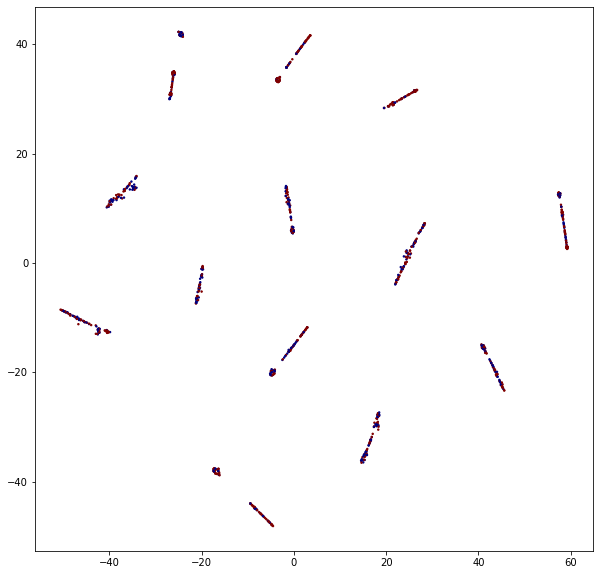

epoch: 1, test: loss_g: 3.4463 loss_g_ae: 3.4288 loss_g_clas: 0.1480 loss_d: 0.0717 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9746 accu_g: 0.9679 accu_g_gdy: 0.9955 bleu: 0.1846 equal: 0.0004 spam: 0.0464 bleu_remain: 0.1670 acc_remain: 0.9952


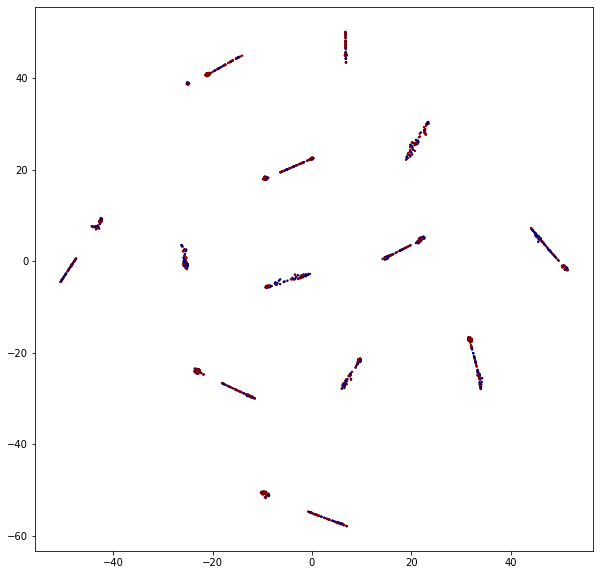

epoch: 1, manual: loss_g: 3.7774 loss_g_ae: 3.7622 loss_g_clas: 0.1698 loss_d: 0.0823 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9680 accu_g: 0.9590 accu_g_gdy: 0.9960 bleu: 0.0768 equal: 0.0000 spam: 0.0460 bleu_remain: 0.0787 acc_remain: 0.9959


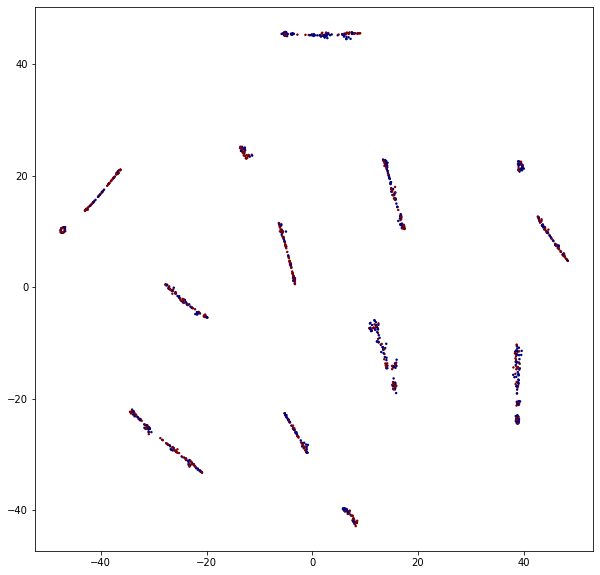

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 2, step: 1, loss_d: 0.0163 accu_d: 1.0000
epoch: 2, step: 1, loss_g: 3.4023 loss_g_ae: 3.3624 loss_g_clas: 0.0918 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9844 accu_g_gdy: 1.0000
epoch: 2, step: 500, loss_d: 0.0454 accu_d: 0.9812
epoch: 2, step: 500, loss_g: 3.4631 loss_g_ae: 3.4473 loss_g_clas: 0.1682 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9547 accu_g_gdy: 0.9469
epoch: 2, step: 1000, loss_d: 0.0495 accu_d: 0.9828
epoch: 2, step: 1000, loss_g: 3.2892 loss_g_ae: 3.2704 loss_g_clas: 0.1953 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9422 accu_g_gdy: 0.9266
epoch: 2, step: 1500, loss_d: 0.0506 accu_d: 0.9781
epoch: 2, step: 1500, loss_g: 3.2496 loss_g_ae: 3.2310 loss_g_clas: 0.2055 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9375 accu_g_gdy: 0.8984
epoch: 2, step: 2000, loss_d: 0.0808 accu_d: 0.9672
epoch: 2, step: 2000, loss_g: 3.

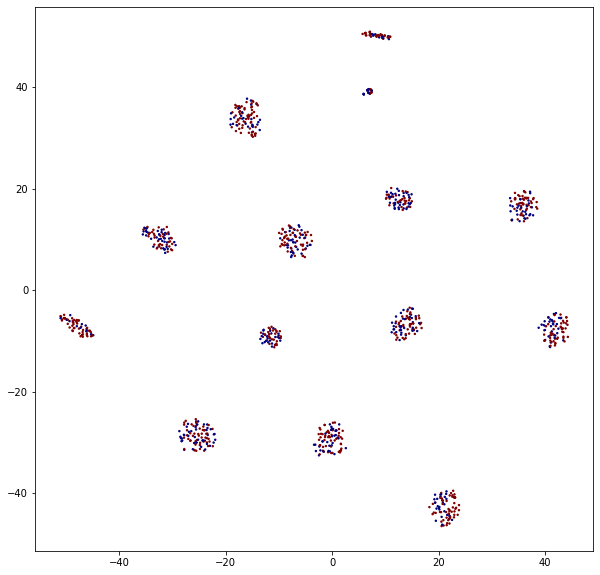

epoch: 2, test: loss_g: 0.2735 loss_g_ae: 0.2728 loss_g_clas: 5.2047 loss_d: 0.0671 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9767 accu_g: 0.1694 accu_g_gdy: 0.1582 bleu: 80.6920 equal: 0.5218 spam: 0.0020 bleu_remain: 63.9854 acc_remain: 0.3110


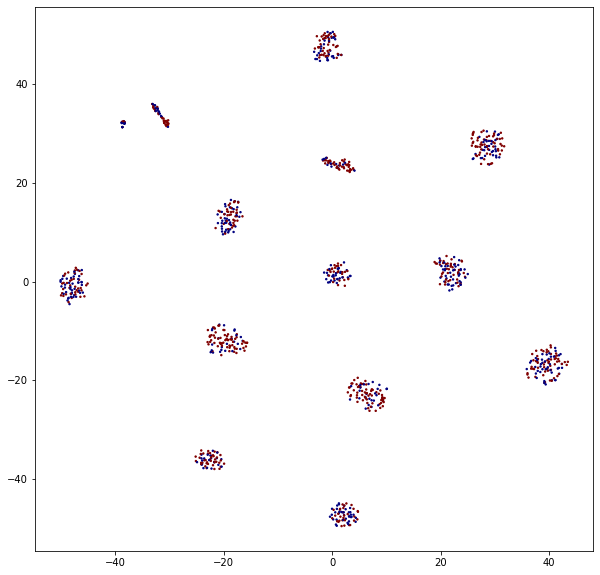

epoch: 2, manual: loss_g: 0.2810 loss_g_ae: 0.2805 loss_g_clas: 5.2404 loss_d: 0.0770 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9740 accu_g: 0.1450 accu_g_gdy: 0.1330 bleu: 81.7712 equal: 0.4850 spam: 0.0030 bleu_remain: 66.3890 acc_remain: 0.2352


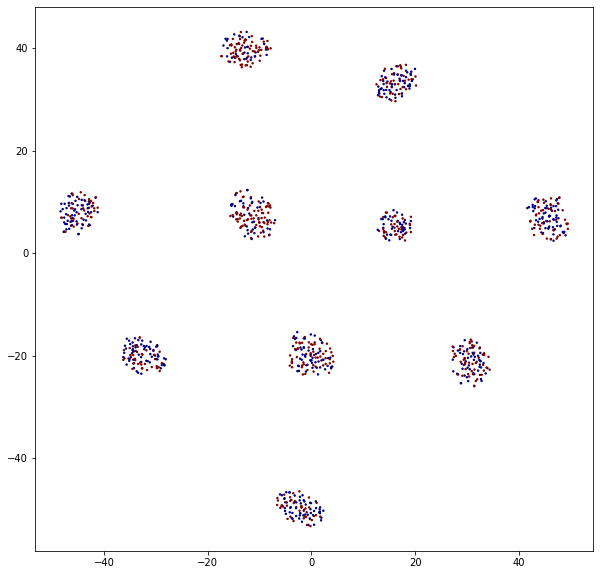

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 3, step: 1, loss_d: 0.0120 accu_d: 1.0000
epoch: 3, step: 1, loss_g: 0.3251 loss_g_ae: 0.3117 loss_g_clas: 4.6723 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1562 accu_g_gdy: 0.1719
epoch: 3, step: 500, loss_d: 0.0392 accu_d: 0.9844
epoch: 3, step: 500, loss_g: 0.4537 loss_g_ae: 0.4241 loss_g_clas: 4.3824 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.2625 accu_g_gdy: 0.2156
epoch: 3, step: 1000, loss_d: 0.0641 accu_d: 0.9828
epoch: 3, step: 1000, loss_g: 0.3290 loss_g_ae: 0.3170 loss_g_clas: 4.7002 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.2172 accu_g_gdy: 0.2094
epoch: 3, step: 1500, loss_d: 0.0393 accu_d: 0.9828
epoch: 3, step: 1500, loss_g: 1.4357 loss_g_ae: 1.1927 loss_g_clas: 3.8298 loss_shifted_ae1: 0.0001 loss_shifted_ae2: 0.0000 accu_g: 0.3156 accu_g_gdy: 0.3250
epoch: 3, step: 2000, loss_d: 0.0838 accu_d: 0.9766
epoch: 3, step: 2000, loss_g: 0.

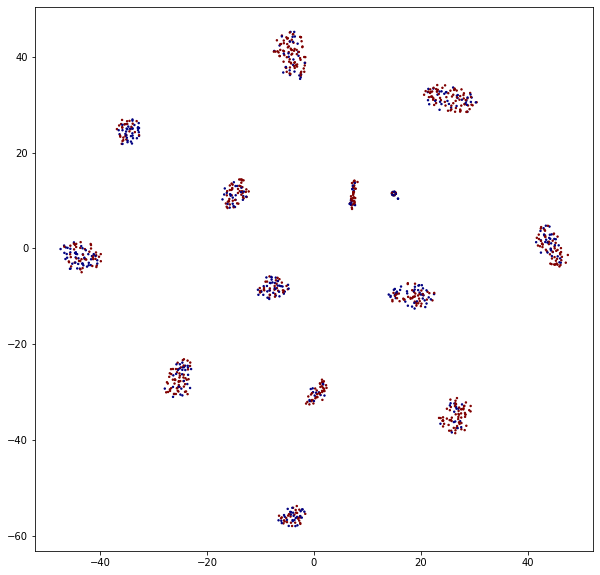

epoch: 3, test: loss_g: 0.1212 loss_g_ae: 0.1210 loss_g_clas: 7.7293 loss_d: 0.0697 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9763 accu_g: 0.0676 accu_g_gdy: 0.0658 bleu: 90.3480 equal: 0.7334 spam: 0.0008 bleu_remain: 69.3601 acc_remain: 0.1916


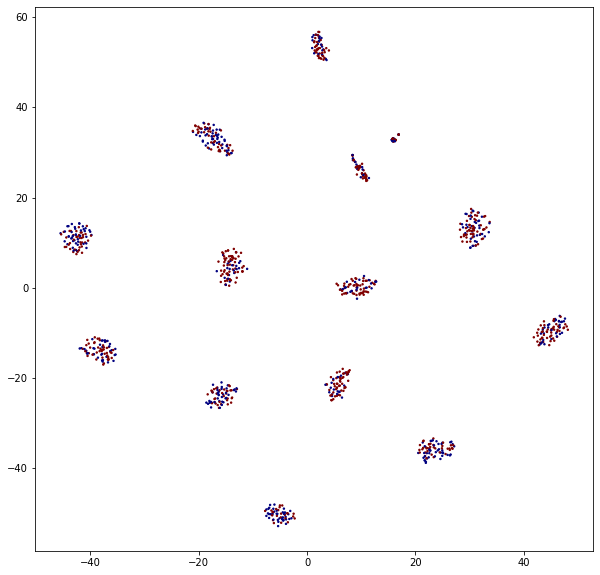

epoch: 3, manual: loss_g: 0.1269 loss_g_ae: 0.1260 loss_g_clas: 7.5023 loss_d: 0.0778 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9790 accu_g: 0.0730 accu_g_gdy: 0.0760 bleu: 91.0545 equal: 0.7110 spam: 0.0010 bleu_remain: 71.0444 acc_remain: 0.2114


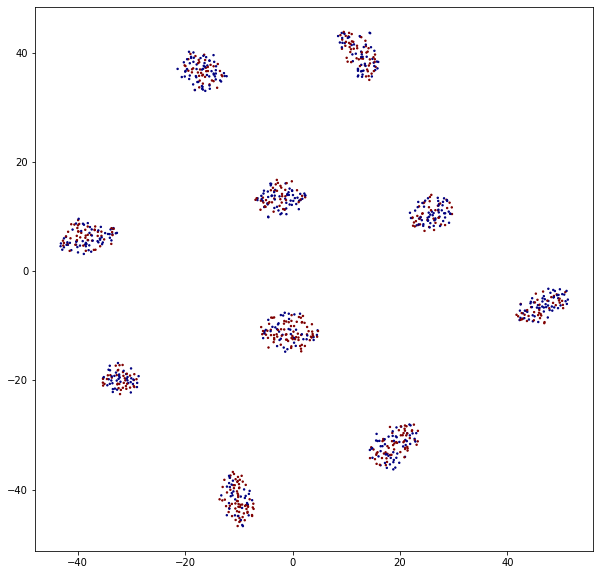

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 4, step: 1, loss_d: 0.0190 accu_d: 1.0000
epoch: 4, step: 1, loss_g: 0.1613 loss_g_ae: 0.1561 loss_g_clas: 7.4331 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1094 accu_g_gdy: 0.0469
epoch: 4, step: 500, loss_d: 0.0275 accu_d: 0.9938
epoch: 4, step: 500, loss_g: 0.1947 loss_g_ae: 0.1850 loss_g_clas: 7.0248 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0984 accu_g_gdy: 0.0984
epoch: 4, step: 1000, loss_d: 0.0228 accu_d: 0.9922
epoch: 4, step: 1000, loss_g: 0.1732 loss_g_ae: 0.1675 loss_g_clas: 6.9643 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1172 accu_g_gdy: 0.1141
epoch: 4, step: 1500, loss_d: 0.0298 accu_d: 0.9875
epoch: 4, step: 1500, loss_g: 0.1551 loss_g_ae: 0.1497 loss_g_clas: 7.3402 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1266 accu_g_gdy: 0.0984
epoch: 4, step: 2000, loss_d: 0.0480 accu_d: 0.9828
epoch: 4, step: 2000, loss_g: 0.

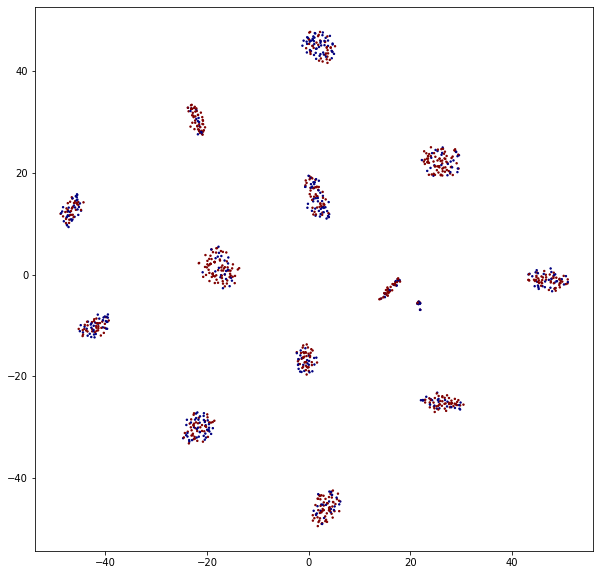

epoch: 4, test: loss_g: 0.0718 loss_g_ae: 0.0717 loss_g_clas: 8.3492 loss_d: 0.0721 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9757 accu_g: 0.0506 accu_g_gdy: 0.0518 bleu: 93.7077 equal: 0.8168 spam: 0.0007 bleu_remain: 71.8308 acc_remain: 0.1886


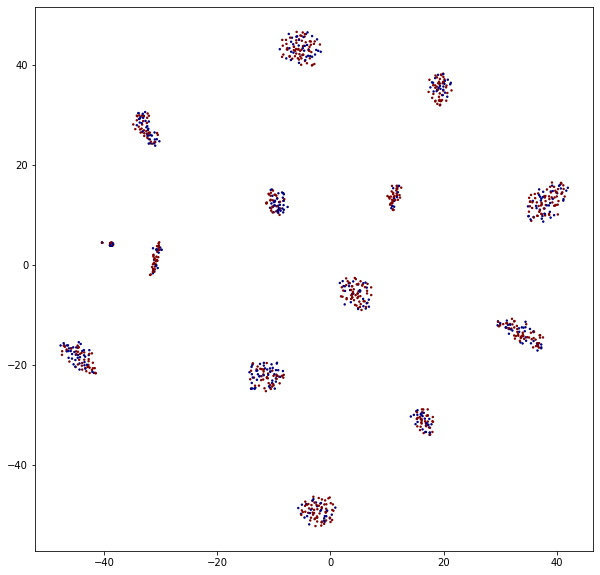

epoch: 4, manual: loss_g: 0.0775 loss_g_ae: 0.0768 loss_g_clas: 8.1683 loss_d: 0.0700 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0580 accu_g_gdy: 0.0600 bleu: 94.3244 equal: 0.8090 spam: 0.0000 bleu_remain: 71.0311 acc_remain: 0.2140


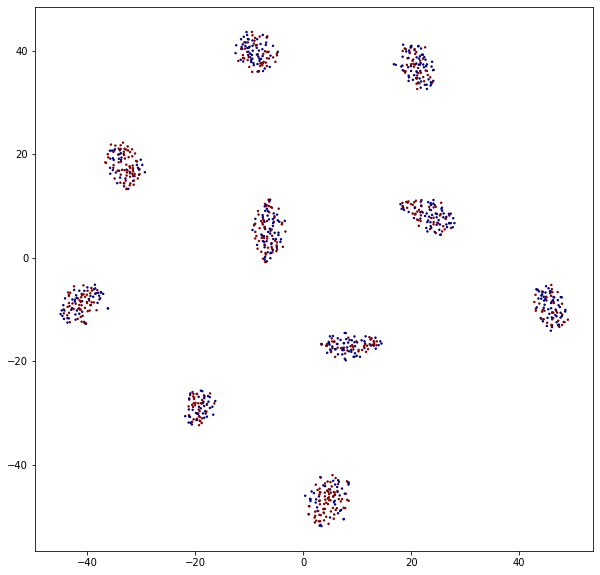

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 5, step: 1, loss_d: 0.0724 accu_d: 0.9844
epoch: 5, step: 1, loss_g: 0.1537 loss_g_ae: 0.1511 loss_g_clas: 8.0677 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0469 accu_g_gdy: 0.0469
epoch: 5, step: 500, loss_d: 0.0391 accu_d: 0.9859
epoch: 5, step: 500, loss_g: 0.1301 loss_g_ae: 0.1278 loss_g_clas: 8.2400 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0719 accu_g_gdy: 0.0875
epoch: 5, step: 1000, loss_d: 0.0196 accu_d: 0.9953
epoch: 5, step: 1000, loss_g: 0.1165 loss_g_ae: 0.1139 loss_g_clas: 8.4732 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0938 accu_g_gdy: 0.0750
epoch: 5, step: 1500, loss_d: 0.0252 accu_d: 0.9906
epoch: 5, step: 1500, loss_g: 0.1138 loss_g_ae: 0.1105 loss_g_clas: 8.8234 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0844 accu_g_gdy: 0.0766
epoch: 5, step: 2000, loss_d: 0.0454 accu_d: 0.9875
epoch: 5, step: 2000, loss_g: 0.

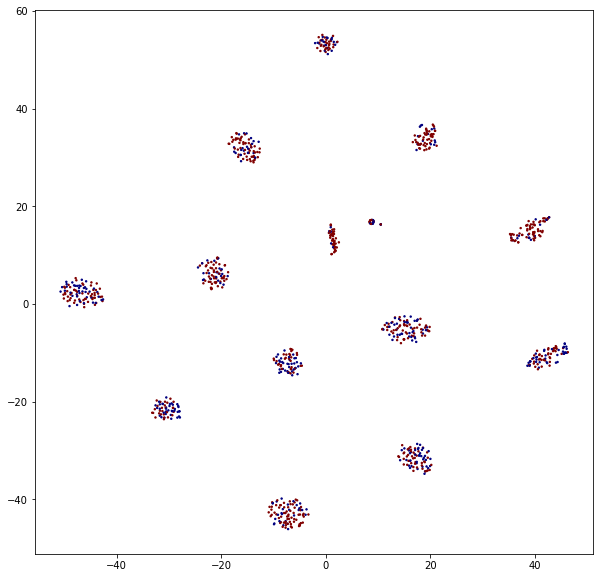

epoch: 5, test: loss_g: 0.0472 loss_g_ae: 0.0470 loss_g_clas: 9.9661 loss_d: 0.0767 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9756 accu_g: 0.0388 accu_g_gdy: 0.0403 bleu: 95.6688 equal: 0.8696 spam: 0.0001 bleu_remain: 72.3632 acc_remain: 0.1633


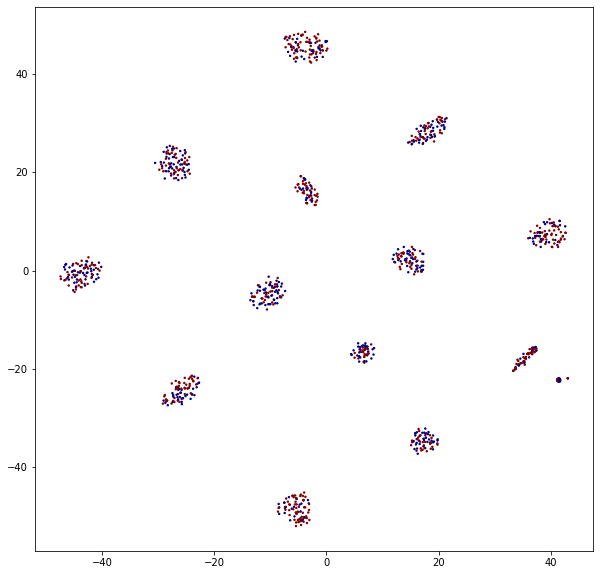

epoch: 5, manual: loss_g: 0.0580 loss_g_ae: 0.0492 loss_g_clas: 9.8371 loss_d: 0.0790 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9780 accu_g: 0.0490 accu_g_gdy: 0.0410 bleu: 96.2246 equal: 0.8700 spam: 0.0000 bleu_remain: 71.2234 acc_remain: 0.1586


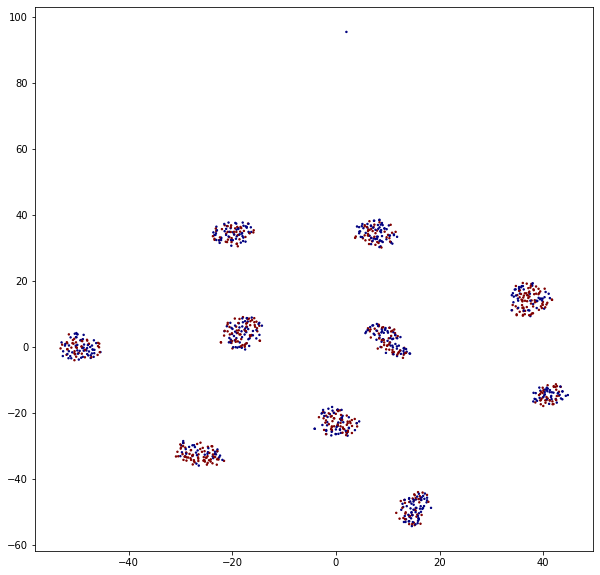

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 6, step: 1, loss_d: 0.0577 accu_d: 0.9688
epoch: 6, step: 1, loss_g: 0.0972 loss_g_ae: 0.0960 loss_g_clas: 9.6130 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0781 accu_g_gdy: 0.0781
epoch: 6, step: 500, loss_d: 0.0269 accu_d: 0.9859
epoch: 6, step: 500, loss_g: 0.0824 loss_g_ae: 0.0811 loss_g_clas: 9.5821 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0734 accu_g_gdy: 0.0625
epoch: 6, step: 1000, loss_d: 0.0491 accu_d: 0.9828
epoch: 6, step: 1000, loss_g: 0.1159 loss_g_ae: 0.1121 loss_g_clas: 9.8999 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0547 accu_g_gdy: 0.0516
epoch: 6, step: 1500, loss_d: 0.0303 accu_d: 0.9938
epoch: 6, step: 1500, loss_g: 0.0791 loss_g_ae: 0.0779 loss_g_clas: 9.4961 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0578 accu_g_gdy: 0.0609
epoch: 6, step: 2000, loss_d: 0.0437 accu_d: 0.9891
epoch: 6, step: 2000, loss_g: 0.

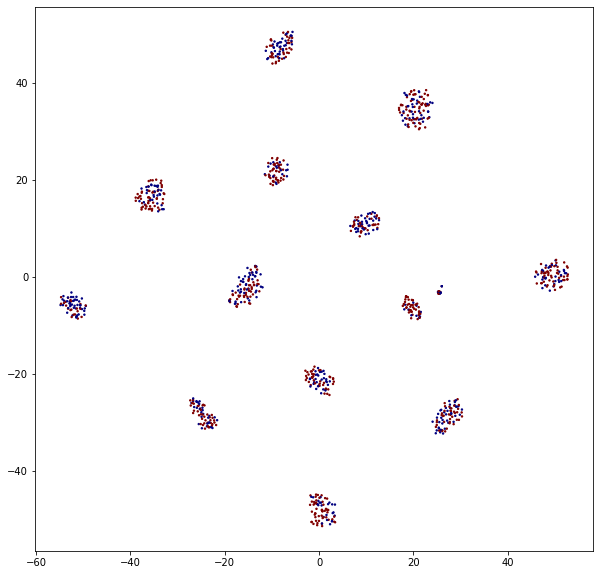

epoch: 6, test: loss_g: 0.0308 loss_g_ae: 0.0307 loss_g_clas: 10.6924 loss_d: 0.0807 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9752 accu_g: 0.0337 accu_g_gdy: 0.0354 bleu: 96.9388 equal: 0.9053 spam: 0.0002 bleu_remain: 72.8084 acc_remain: 0.1567


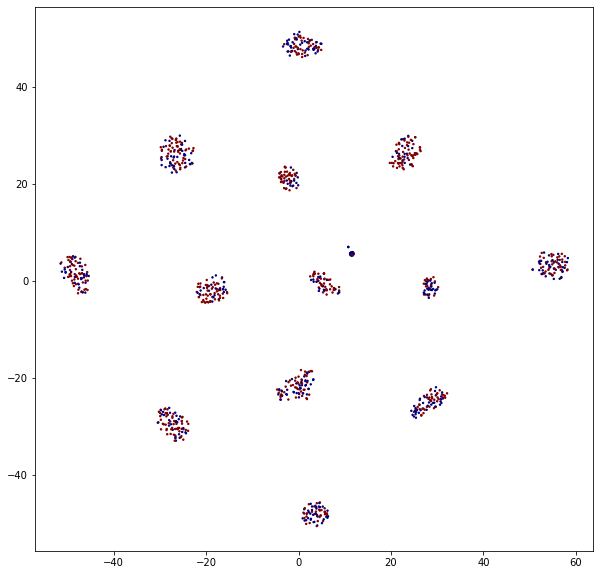

epoch: 6, manual: loss_g: 0.0310 loss_g_ae: 0.0289 loss_g_clas: 10.6332 loss_d: 0.0711 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9770 accu_g: 0.0370 accu_g_gdy: 0.0320 bleu: 97.7990 equal: 0.9230 spam: 0.0000 bleu_remain: 71.1662 acc_remain: 0.1761


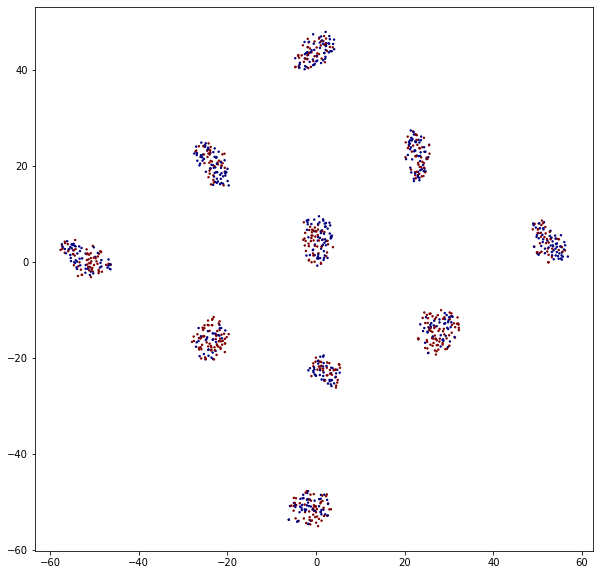

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 7, step: 1, loss_d: 0.0336 accu_d: 1.0000
epoch: 7, step: 1, loss_g: 0.0851 loss_g_ae: 0.0834 loss_g_clas: 10.3657 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0625 accu_g_gdy: 0.0469
epoch: 7, step: 500, loss_d: 0.0154 accu_d: 0.9969
epoch: 7, step: 500, loss_g: 0.0978 loss_g_ae: 0.0902 loss_g_clas: 10.3781 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0891 accu_g_gdy: 0.0766
epoch: 7, step: 1000, loss_d: 0.0318 accu_d: 0.9891
epoch: 7, step: 1000, loss_g: 0.0586 loss_g_ae: 0.0572 loss_g_clas: 10.5917 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0484 accu_g_gdy: 0.0484
epoch: 7, step: 1500, loss_d: 0.0192 accu_d: 0.9938
epoch: 7, step: 1500, loss_g: 0.0660 loss_g_ae: 0.0646 loss_g_clas: 11.4860 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0422 accu_g_gdy: 0.0375
epoch: 7, step: 2000, loss_d: 0.0325 accu_d: 0.9891
epoch: 7, step: 2000, loss_g

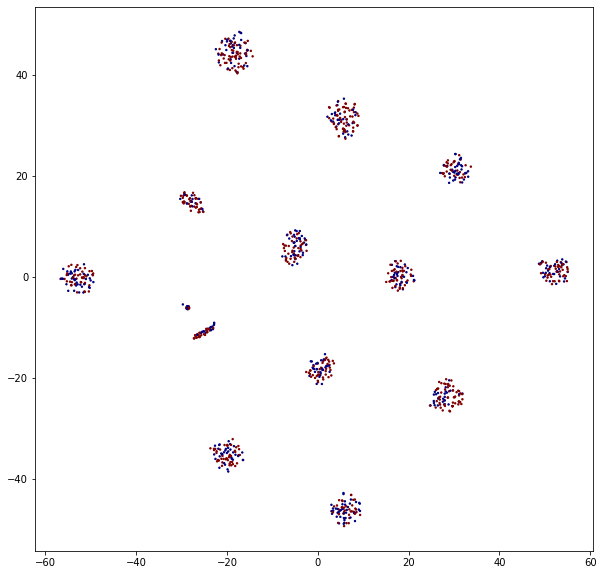

epoch: 7, test: loss_g: 0.0249 loss_g_ae: 0.0248 loss_g_clas: 11.4130 loss_d: 0.0855 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9750 accu_g: 0.0325 accu_g_gdy: 0.0339 bleu: 97.4005 equal: 0.9198 spam: 0.0001 bleu_remain: 72.8530 acc_remain: 0.1529


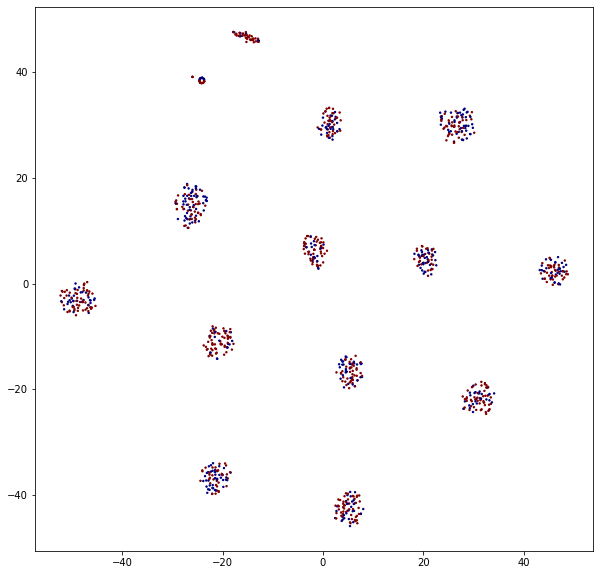

epoch: 7, manual: loss_g: 0.0355 loss_g_ae: 0.0265 loss_g_clas: 11.3705 loss_d: 0.0803 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0290 accu_g_gdy: 0.0360 bleu: 97.9295 equal: 0.9300 spam: 0.0000 bleu_remain: 65.3480 acc_remain: 0.1615


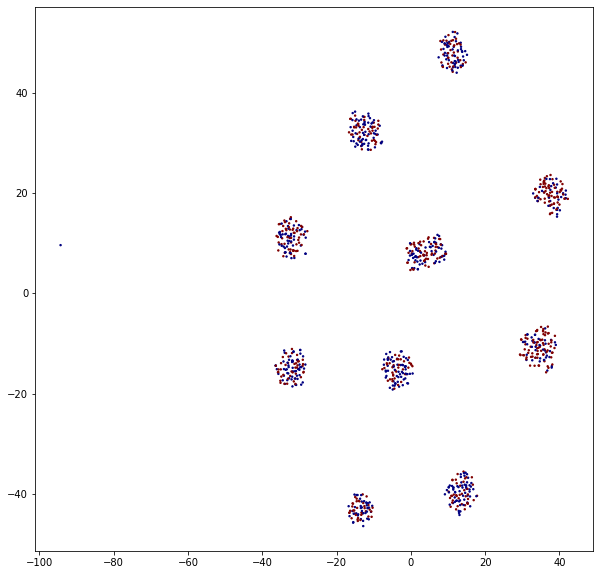

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 8, step: 1, loss_d: 0.0135 accu_d: 1.0000
epoch: 8, step: 1, loss_g: 0.0498 loss_g_ae: 0.0489 loss_g_clas: 10.7956 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0625
epoch: 8, step: 500, loss_d: 0.0261 accu_d: 0.9922
epoch: 8, step: 500, loss_g: 0.0575 loss_g_ae: 0.0562 loss_g_clas: 11.7215 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0094 accu_g_gdy: 0.0203
epoch: 8, step: 1000, loss_d: 0.0080 accu_d: 0.9984
epoch: 8, step: 1000, loss_g: 0.0736 loss_g_ae: 0.0704 loss_g_clas: 12.0782 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0375 accu_g_gdy: 0.0359
epoch: 8, step: 1500, loss_d: 0.0210 accu_d: 0.9922
epoch: 8, step: 1500, loss_g: 0.0447 loss_g_ae: 0.0437 loss_g_clas: 12.5321 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0250 accu_g_gdy: 0.0297
epoch: 8, step: 2000, loss_d: 0.0135 accu_d: 0.9922
epoch: 8, step: 2000, loss_g

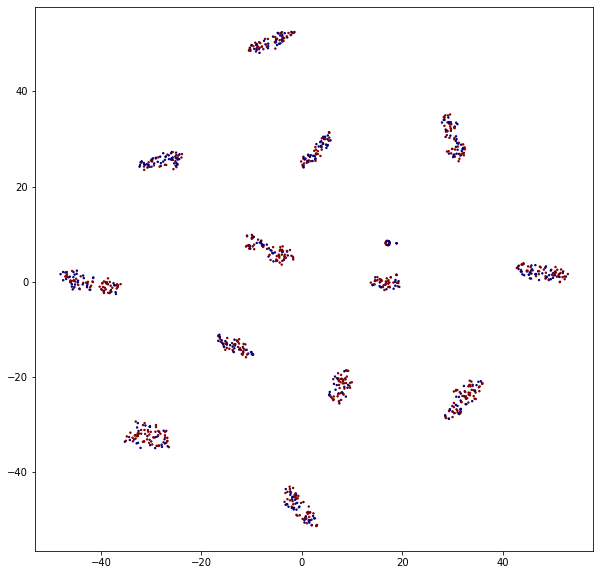

epoch: 8, test: loss_g: 0.0182 loss_g_ae: 0.0180 loss_g_clas: 12.4477 loss_d: 0.0955 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9737 accu_g: 0.0304 accu_g_gdy: 0.0321 bleu: 98.1934 equal: 0.9425 spam: 0.0000 bleu_remain: 70.2994 acc_remain: 0.1446


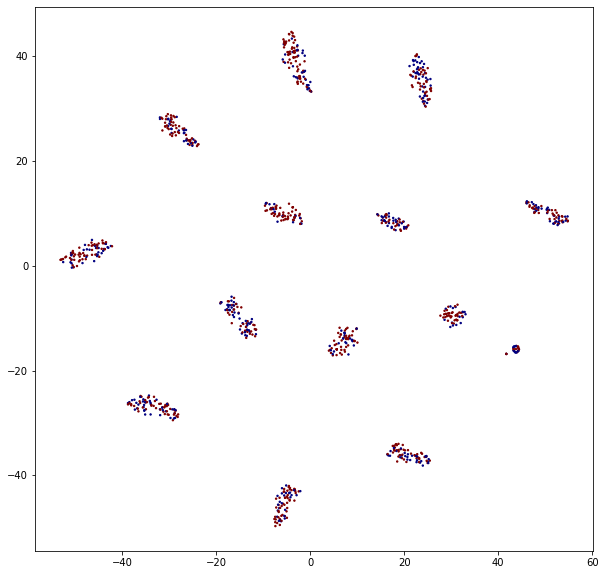

epoch: 8, manual: loss_g: 0.0254 loss_g_ae: 0.0194 loss_g_clas: 12.5849 loss_d: 0.0770 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9790 accu_g: 0.0280 accu_g_gdy: 0.0290 bleu: 98.1970 equal: 0.9330 spam: 0.0000 bleu_remain: 74.0250 acc_remain: 0.1664


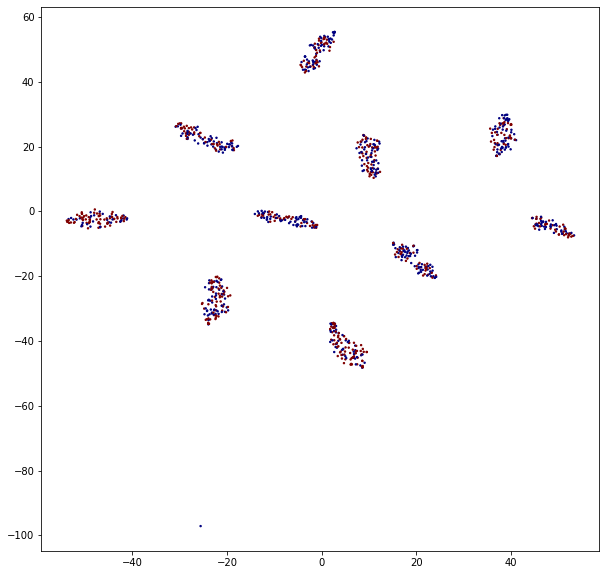

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 9, step: 1, loss_d: 0.0006 accu_d: 1.0000
epoch: 9, step: 1, loss_g: 0.0452 loss_g_ae: 0.0411 loss_g_clas: 12.9477 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0156 accu_g_gdy: 0.0156
epoch: 9, step: 500, loss_d: 0.0345 accu_d: 0.9938
epoch: 9, step: 500, loss_g: 0.0430 loss_g_ae: 0.0419 loss_g_clas: 12.5448 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0344 accu_g_gdy: 0.0312
epoch: 9, step: 1000, loss_d: 0.0182 accu_d: 0.9953
epoch: 9, step: 1000, loss_g: 0.0315 loss_g_ae: 0.0307 loss_g_clas: 13.3124 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0281 accu_g_gdy: 0.0312
epoch: 9, step: 1500, loss_d: 0.0100 accu_d: 0.9969
epoch: 9, step: 1500, loss_g: 0.0519 loss_g_ae: 0.0481 loss_g_clas: 13.0582 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0297 accu_g_gdy: 0.0297
epoch: 9, step: 2000, loss_d: 0.0197 accu_d: 0.9953
epoch: 9, step: 2000, loss_g

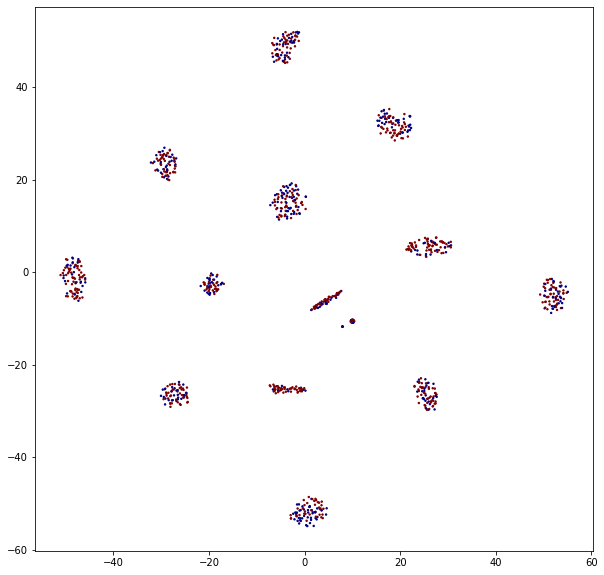

epoch: 9, test: loss_g: 0.0135 loss_g_ae: 0.0133 loss_g_clas: 13.0745 loss_d: 0.0990 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9732 accu_g: 0.0314 accu_g_gdy: 0.0326 bleu: 98.5430 equal: 0.9540 spam: 0.0000 bleu_remain: 68.3899 acc_remain: 0.1625


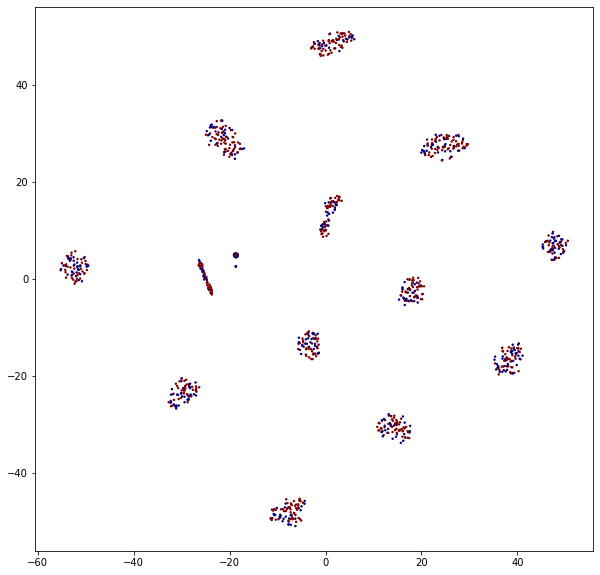

epoch: 9, manual: loss_g: 0.0127 loss_g_ae: 0.0120 loss_g_clas: 13.1237 loss_d: 0.0892 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9790 accu_g: 0.0240 accu_g_gdy: 0.0260 bleu: 98.7158 equal: 0.9530 spam: 0.0010 bleu_remain: 65.6682 acc_remain: 0.0902


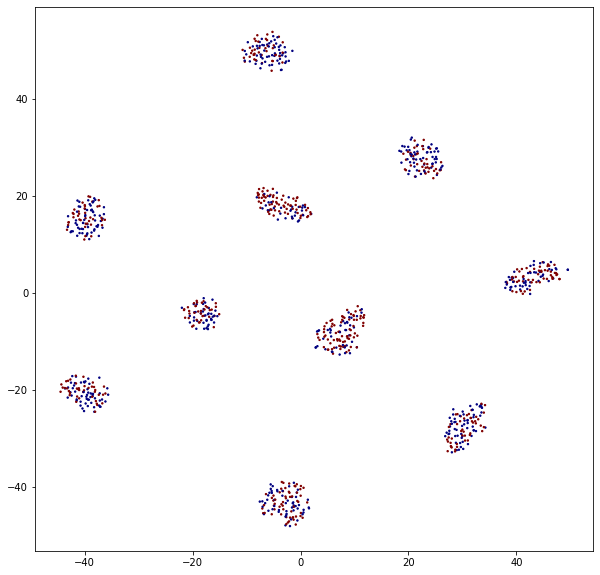

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 10, step: 1, loss_d: 0.0013 accu_d: 1.0000
epoch: 10, step: 1, loss_g: 0.0397 loss_g_ae: 0.0387 loss_g_clas: 13.7339 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0156 accu_g_gdy: 0.0000
epoch: 10, step: 500, loss_d: 0.0103 accu_d: 0.9953
epoch: 10, step: 500, loss_g: 0.0274 loss_g_ae: 0.0266 loss_g_clas: 14.5354 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0266 accu_g_gdy: 0.0156
epoch: 10, step: 1000, loss_d: 0.0176 accu_d: 0.9938
epoch: 10, step: 1000, loss_g: 0.0385 loss_g_ae: 0.0375 loss_g_clas: 13.5959 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0172 accu_g_gdy: 0.0297
epoch: 10, step: 1500, loss_d: 0.0337 accu_d: 0.9891
epoch: 10, step: 1500, loss_g: 0.0390 loss_g_ae: 0.0332 loss_g_clas: 14.4439 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0125 accu_g_gdy: 0.0250
epoch: 10, step: 2000, loss_d: 0.0071 accu_d: 1.0000
epoch: 10, step: 20

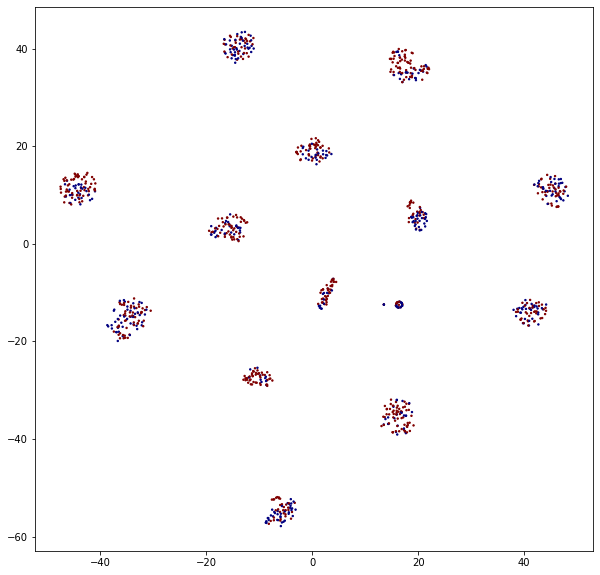

epoch: 10, test: loss_g: 0.0101 loss_g_ae: 0.0100 loss_g_clas: 14.0112 loss_d: 0.1053 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9735 accu_g: 0.0299 accu_g_gdy: 0.0305 bleu: 98.9285 equal: 0.9657 spam: 0.0000 bleu_remain: 64.2037 acc_remain: 0.1535


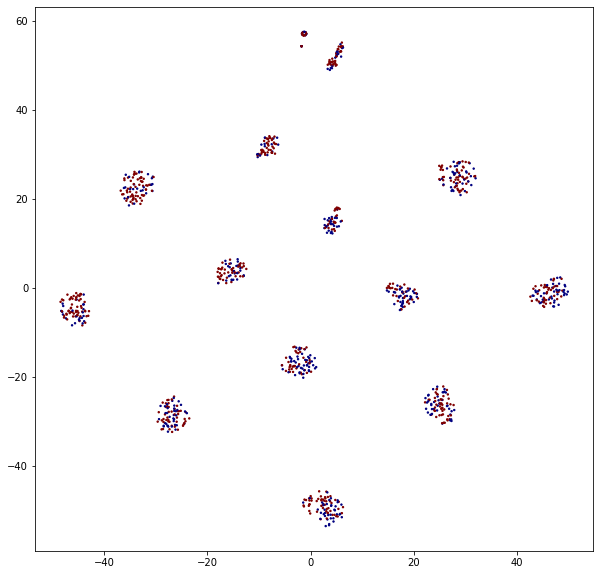

epoch: 10, manual: loss_g: 0.1376 loss_g_ae: 0.0110 loss_g_clas: 14.1807 loss_d: 0.0856 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9780 accu_g: 0.0270 accu_g_gdy: 0.0280 bleu: 99.0560 equal: 0.9640 spam: 0.0000 bleu_remain: 71.8272 acc_remain: 0.1440


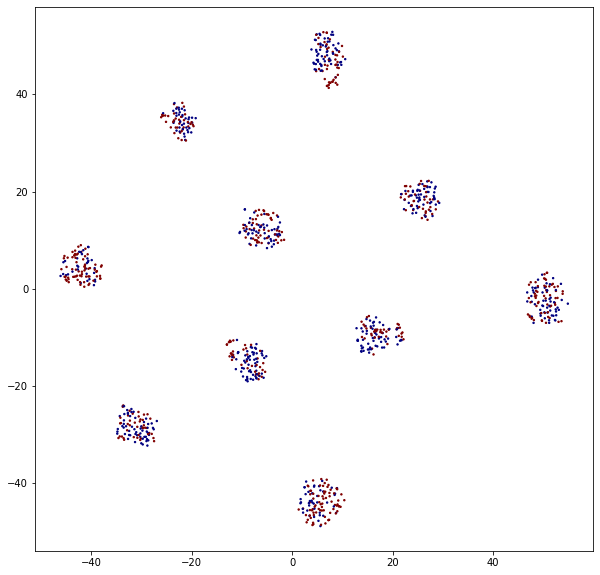

gamma: 0.5, lambda_g: 0.1, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 11, step: 1, loss_d: 0.0070 accu_d: 1.0000
epoch: 11, step: 1, loss_g: 1.4664 loss_g_ae: 0.0257 loss_g_clas: 14.3956 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0469 accu_g_gdy: 0.0312
epoch: 11, step: 500, loss_d: 0.0119 accu_d: 0.9938
epoch: 11, step: 500, loss_g: 0.3529 loss_g_ae: 0.2145 loss_g_clas: 1.3412 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7984 accu_g_gdy: 0.7984
epoch: 11, step: 1500, loss_d: 0.0074 accu_d: 0.9984
epoch: 11, step: 1500, loss_g: 0.2739 loss_g_ae: 0.1856 loss_g_clas: 0.8566 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8719 accu_g_gdy: 0.8656
epoch: 11, step: 2000, loss_d: 0.0230 accu_d: 0.9906
epoch: 11, step: 2000, loss_g: 0.2576 loss_g_ae: 0.1509 loss_g_clas: 0.9641 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8516 accu_g_gdy: 0.8453
epoch: 11, step: 2500, loss_d: 0.0177 accu_d: 0.9938
epoch: 11, step: 2500,

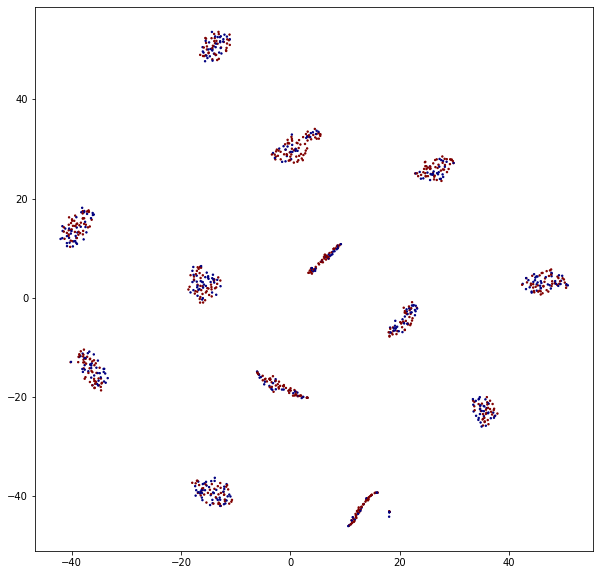

epoch: 11, test: loss_g: 0.1352 loss_g_ae: 0.0579 loss_g_clas: 0.7701 loss_d: 0.1106 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9730 accu_g: 0.8740 accu_g_gdy: 0.8738 bleu: 64.9537 equal: 0.1012 spam: 0.0002 bleu_remain: 60.1610 acc_remain: 0.9542


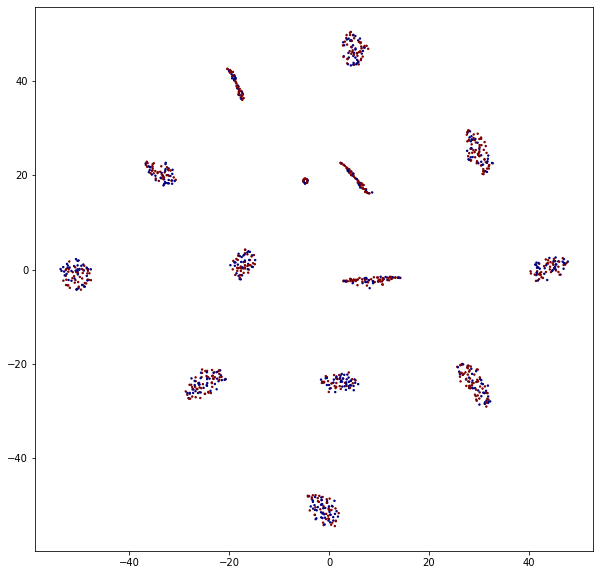

epoch: 11, manual: loss_g: 0.1431 loss_g_ae: 0.0604 loss_g_clas: 0.8224 loss_d: 0.0804 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9840 accu_g: 0.8550 accu_g_gdy: 0.8500 bleu: 67.4010 equal: 0.1150 spam: 0.0000 bleu_remain: 62.4623 acc_remain: 0.9482


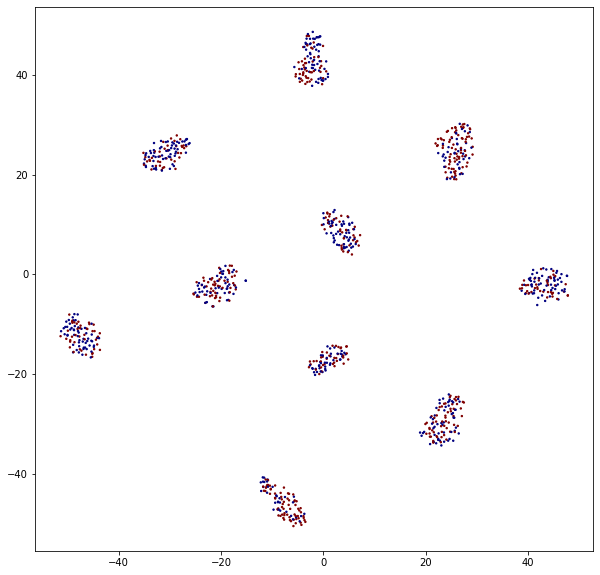

gamma: 0.25, lambda_g: 0.1, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 12, step: 1, loss_d: 0.0020 accu_d: 1.0000
epoch: 12, step: 1, loss_g: 0.2145 loss_g_ae: 0.1479 loss_g_clas: 0.6435 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9219 accu_g_gdy: 0.8750
epoch: 12, step: 500, loss_d: 0.0290 accu_d: 0.9938
epoch: 12, step: 500, loss_g: 0.2360 loss_g_ae: 0.1305 loss_g_clas: 0.8991 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8688 accu_g_gdy: 0.8766
epoch: 12, step: 1000, loss_d: 0.0124 accu_d: 0.9922
epoch: 12, step: 1000, loss_g: 0.1977 loss_g_ae: 0.1146 loss_g_clas: 0.7843 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8766 accu_g_gdy: 0.8719
epoch: 12, step: 1500, loss_d: 0.0105 accu_d: 0.9984
epoch: 12, step: 1500, loss_g: 0.2024 loss_g_ae: 0.0959 loss_g_clas: 0.9750 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8641 accu_g_gdy: 0.8766
epoch: 12, step: 2000, loss_d: 0.0118 accu_d: 0.9938
epoch: 12, step: 2000,

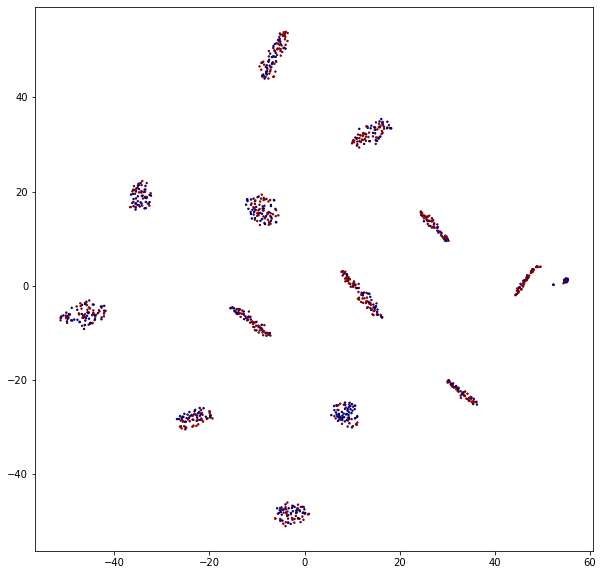

epoch: 12, test: loss_g: 0.1467 loss_g_ae: 0.0677 loss_g_clas: 0.7810 loss_d: 0.1174 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9726 accu_g: 0.8797 accu_g_gdy: 0.8795 bleu: 63.9387 equal: 0.0929 spam: 0.0003 bleu_remain: 59.6157 acc_remain: 0.9525


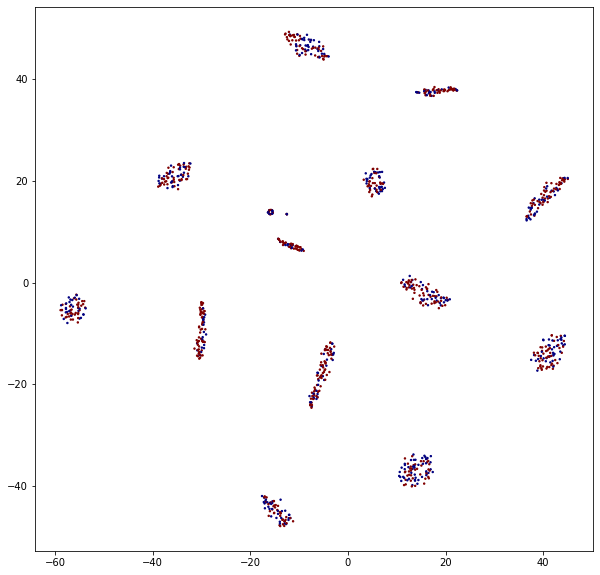

epoch: 12, manual: loss_g: 0.1822 loss_g_ae: 0.0817 loss_g_clas: 0.9999 loss_d: 0.0993 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9740 accu_g: 0.8480 accu_g_gdy: 0.8450 bleu: 67.0972 equal: 0.1130 spam: 0.0000 bleu_remain: 62.2031 acc_remain: 0.9382


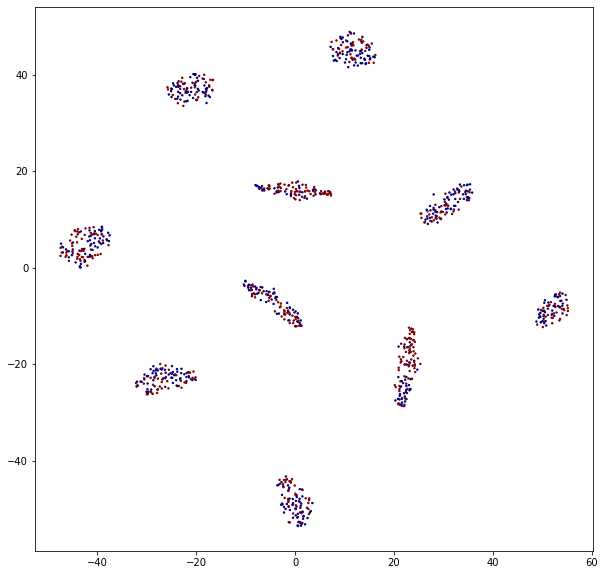

In [49]:
train_model()

In [50]:
print_result()

[['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'], ['i was so scared and they made me feel very at ease .', 1, 'i was so scared and they made me feel very at zero .', 0, 0.842362674378975], ['the owners are fair and honest , helpful and efficient .', 1, 'the owners are sadly and lacking , helpful and efficient .', 0, 0.4832697830906221], ['it had zero flavor period .', 0, 'it had ease flavor period .', 1, 0.7008534286706599], ['sushi happy hour is the hidden secret .', 1, 'sushi noisy hour is the worst secret .', 0, 0.4905457530262492], ['we were beyond pleased with the taste and quality of the bagels !', 1, 'we were beyond avoid with the taste and lacking of the bagels !', 0, 0.4758733096412523], ["server again disappeared in between my husband 's plate being removed and my finishing .", 0, "server again matthew in between my husband 's plate being throughly and my loves .", 1, 0.4920274515385508], ['would recommend to anyone .', 1, 'would allergic to